
<img src="https://news.illinois.edu/files/6367/543635/116641.jpg" alt="University of Illinois" width="250"/>

# PyTorch implementation of Linear Regression #
By Richard Sowers
* <r-sowers@illinois.edu>
* <https://publish.illinois.edu/r-sowers/>

Copyright 2020 University of Illinois Board of Trustees. All Rights Reserved.

Pytorch documentation: <https://pytorch.org/docs/stable/index.html>

# imports and graphics configurations #

In [ ]:
import os
import numpy
import pandas
import time
import random
import matplotlib
#%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import scipy.stats
#from pandas.plotting import autocorrelation_plot
import matplotlib.offsetbox as offsetbox
from matplotlib.ticker import StrMethodFormatter

import imageio
import PIL

def saver(fname):
    plt.savefig(fname+".png",bbox_inches="tight")

def legend(pos="bottom",ncol=3,extra=False):
    if pos=="bottom":
        extra = 0.15 if extra else 0
        plt.legend(bbox_to_anchor=(0.5,-0.2-extra), loc='upper center',facecolor="lightgray",ncol=ncol)
    elif pos=="side":
        plt.legend(bbox_to_anchor=(1.1,0.5), loc='center left',facecolor="lightgray",ncol=1)

def textbox(txt,fname=None):
    plt.figure(figsize=(1,1))
    plt.gca().add_artist(offsetbox.AnchoredText("\n".join(txt), loc="center",prop=dict(size=30)))
    plt.axis('off')
    if fname is not None:
        saver(fname)
    plt.show()
    plt.close()

In [ ]:
import torch
import scipy

In [ ]:
#for some reason, this needs to be in a separate cell
params={
    "font.size":15,
    "lines.linewidth":5
}
plt.rcParams.update(params)

In [ ]:
pngfiles=[f for f in os.listdir(".") if f.endswith(".png")]
print("existing png files: "+str(pngfiles))
#print([os.remove(f) for f in pngfiles])

existing png files: []


In [ ]:
def getfile(location_pair,**kwargs): #tries to get local version and then defaults to google drive version
    (loc,gdrive)=location_pair
    try:
        out=pandas.read_csv(loc,**kwargs)
    except FileNotFoundError:
        print("local file not found; accessing Google Drive")
        loc = 'https://drive.google.com/uc?export=download&id='+gdrive.split('/')[-2]
        out=pandas.read_csv(loc,**kwargs)
    return out

# configuration variables #

In [ ]:
url="https://www.redfin.com"
fname=("redfin_data.csv","https://drive.google.com/file/d/1ei7JaZ4M1lrw3TyYcWozESi8HrHccnUx/view?usp=sharing")
plot_title="Home Asking Price (Redfin)"
data_color="red"
markersize=2
thinlinesize=2

In [ ]:
(feature,featurescale,featurename)=("SQUARE FEET",1000,"SQUARE FEET/1000")
(label,labelscale,labelname)=("PRICE",1.0E6,"PRICE/$1M")

# load data #

In [ ]:
data_raw=getfile(fname)
data_raw.head()

local file not found; accessing Google Drive


,SALE TYPE,SOLD DATE,PROPERTY TYPE,ADDRESS,CITY,STATE OR PROVINCE,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,...,STATUS,NEXT OPEN HOUSE START TIME,NEXT OPEN HOUSE END TIME,URL (SEE https://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING),SOURCE,MLS#,FAVORITE,INTERESTED,LATITUDE,LONGITUDE
0,MLS Listing,NaN,Condo/Co-op,1316 Maple Ave Unit A3,Evanston,IL,60201,549000,3.0,2.5,...,Active,NaN,NaN,https://www.redfin.com/IL/Evanston/1316-Maple-...,MRED,11329016,N,Y,42.041893,-87.685418
1,MLS Listing,NaN,Condo/Co-op,1640 Maple Ave #1608,Evanston,IL,60201,925000,2.0,2.5,...,Active,NaN,NaN,https://www.redfin.com/IL/Evanston/1640-Maple-...,MRED,11324990,N,Y,42.048207,-87.685582
2,MLS Listing,NaN,Single Family Residential,9400 Drake Ave,Evanston,IL,60203,699900,5.0,2.0,...,Active,NaN,NaN,https://www.redfin.com/IL/Evanston/9400-Drake-...,MRED,11328594,N,Y,42.051958,-87.717069
3,MLS Listing,NaN,Condo/Co-op,2320 Central St #304,Evanston,IL,60201,315000,2.0,2.0,...,Active,NaN,NaN,https://www.redfin.com/IL/Evanston/2320-Centra...,MRED,11328430,N,Y,42.064059,-87.705756
4,MLS Listing,NaN,Townhouse,9032 Forestview Rd,Evanston,IL,60203,385000,2.0,2.5,...,Active,NaN,NaN,https://www.redfin.com/IL/Evanston/9032-Forest...,MRED,11328152,N,Y,42.045487,-87.714740


In [ ]:
data=data_raw.copy()
data.index+=1
data.index.name="record number"

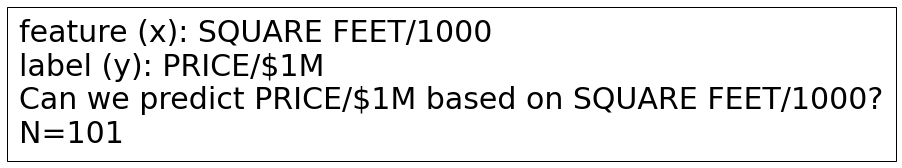

In [ ]:
text=[]
text.append("feature (x): {0:s}".format(featurename))
text.append("label (y): {0:s}".format(labelname))
text.append("Can we predict {0:s} based on {1:s}?".format(labelname,featurename))
text.append("N={0:d}".format(len(data)))
textbox(text,fname="dataset")

In [ ]:
XY=data[[feature,label]].dropna(axis='index')
XY.columns=[featurename,labelname]
XY[featurename]=XY[featurename]/featurescale
XY[labelname]=XY[labelname]/labelscale
XY.head()

,SQUARE FEET/1000,PRICE/$1M
record number,,
1,2.000,0.5490
2,2.138,0.9250
3,2.198,0.6999
4,1.426,0.3150
7,2.170,0.7390


In [ ]:
X=XY[featurename].squeeze()
Y=XY[labelname].squeeze()
m_sp,b_sp,_,_,_=scipy.stats.linregress(X,Y)
print("scipy: m_sp = {0:} and b_sp= {1:}".format(m_sp,b_sp))

scipy: m_sp = 0.3558718716000352 and b_sp= -0.1403975081292415


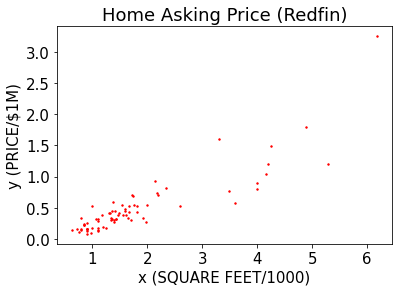

In [ ]:
plt.figure()
plt.scatter(X,Y,color=data_color,s=markersize)
title=[]
title.append(plot_title)
plt.title("\n".join(title))
plt.xlabel("x ({0:s})".format(featurename))
plt.ylabel("y ({0:s})".format(labelname))
#tick = mtick.StrMethodFormatter("${x:,.0f}")
#plt.gca().yaxis.set_major_formatter(tick)
saver("xyplot")
plt.show()
plt.close()

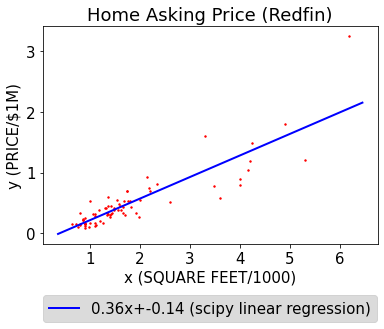

In [ ]:
plt.figure()
plt.scatter(X,Y,color=data_color,s=markersize)
xlims=numpy.array(plt.gca().get_xlim())
plt.plot(xlims,m_sp*xlims+b_sp,label="{0:.2f}x+{1:.2f} (scipy linear regression)".format(m_sp,b_sp),color="blue",linewidth=thinlinesize)
title=[]
title.append(plot_title)
plt.title("\n".join(title))
plt.xlabel("x ({0:s})".format(featurename))
plt.ylabel("y ({0:s})".format(labelname))
#tick = mtick.StrMethodFormatter("${x:,.0f}")
#plt.gca().yaxis.set_major_formatter(tick)
legend("bottom")
saver("bestlines")
plt.show()
plt.close()

## Implement with PyTorch ##

In [ ]:
features=torch.from_numpy(X.values.astype(numpy.float32).reshape(-1,1))
labels=torch.from_numpy(Y.values.astype(numpy.float32).reshape(-1,1))

print("cuda available: {:}".format(torch.cuda.is_available()))
features = features.cuda() if torch.cuda.is_available() else features
labels = labels.cuda() if torch.cuda.is_available() else labels

cuda available: False


In [ ]:
learningRate=0.075

In [ ]:
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize=1, outputSize=1,SEED=0): #default to one-dimensional feature and response
        super().__init__() #run init of torch.nn.Module
        if SEED is not None:
          torch.manual_seed(SEED)
        self.linear = torch.nn.Linear(inputSize,outputSize)
        if torch.cuda.is_available():
          self=self.cuda()

    def forward(self, x):
        out=self.linear(x)
        return out

model=linearRegression()

Loss = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

In [ ]:
MAX_iter = 100
starttime=time.time()
for itr in range(MAX_iter):

    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = model(features)

    # get loss for the predicted output
    lossvalue = Loss(outputs, labels)

    # get gradients w.r.t to parameters
    lossvalue.backward()
    #print(model.linear.weight.grad.item(),model.linear.bias.grad.item())

    # update parameters
    optimizer.step()
    if itr%int(MAX_iter/10)==0:
      print("iteration {}: loss={:.5f}, m={:.3f}, b={:.2f}, d/dm={:.2f}, d/db={:.2f}".format(itr, lossvalue.item(),
        model.linear.weight.item(),model.linear.bias.item(),model.linear.weight.grad.item(),model.linear.bias.grad.item()))

endtime=time.time()
print("\nexecution time: {0:.5f} seconds".format(endtime-starttime))

iteration 0: loss=0.05207, m=0.356, b=-0.14, d/dm=-0.00, d/db=0.00
iteration 10: loss=0.05207, m=0.356, b=-0.14, d/dm=-0.00, d/db=0.00
iteration 20: loss=0.05207, m=0.356, b=-0.14, d/dm=-0.00, d/db=0.00
iteration 30: loss=0.05207, m=0.356, b=-0.14, d/dm=-0.00, d/db=0.00
iteration 40: loss=0.05207, m=0.356, b=-0.14, d/dm=-0.00, d/db=0.00
iteration 50: loss=0.05207, m=0.356, b=-0.14, d/dm=-0.00, d/db=0.00
iteration 60: loss=0.05207, m=0.356, b=-0.14, d/dm=-0.00, d/db=0.00
iteration 70: loss=0.05207, m=0.356, b=-0.14, d/dm=-0.00, d/db=0.00
iteration 80: loss=0.05207, m=0.356, b=-0.14, d/dm=-0.00, d/db=0.00
iteration 90: loss=0.05207, m=0.356, b=-0.14, d/dm=-0.00, d/db=0.00

execution time: 0.04314 seconds


In [ ]:
(m_pt,b_pt)=(model.linear.weight.item(),model.linear.bias.item())

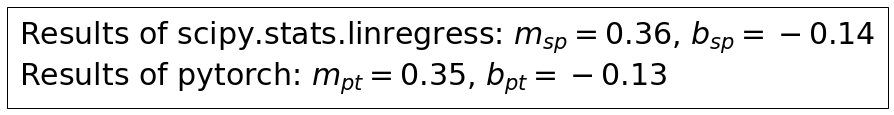

In [ ]:
text=[]
text.append("Results of scipy.stats.linregress: $m_{{sp}}={0:.2f}$, $b_{{sp}}={1:.2f}$".format(m_sp,b_sp))
text.append("Results of pytorch: $m_{{pt}}={0:.2f}$, $b_{{pt}}={1:.2f}$".format(m_pt,b_pt))
textbox(text)